# Rossman 销售额预测 -- 进行机器学习预测

这里将使用特征工程 Feature Engineering notebook 整理的成果进行预测，在预测过程中，我要使用RMPSE作为评价方法来反应模型的表现。

In [1]:
from sklearn.metrics import make_scorer

def RMSPE(test,pred):
    # 在特征工程中，Sales被取对数，这里计算评分时要还原
    test = np.e**test
    pred = np.e**pred
    return np.sqrt(np.mean(((test-pred)/pred)**2))
scorer = make_scorer(RMSPE)

## 1. Random Forest

In [30]:
# 引用必要的库
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold

# 读入数据集
cesar_train = pd.read_csv('data/cesar_train.csv',index_col=False)
cesar_test = pd.read_csv('data/cesar_test.csv',index_col=False)
X = cesar_train.drop(['Sales'],axis=1)
y = cesar_train.Sales

### 1.1. Random Forest default

使用默认参数下的随机森林回归算法

In [3]:
# 建立最基础的随机森林回归器
RF_alpha = RandomForestRegressor()
# 将训练集进行再划分
X_train, X_test, y_train, y_test = train_test_split(X, y)
# 进行训练和评价
RF_alpha = RF_alpha.fit(X_train,y_train)
y_pred = RF_alpha.predict(X_test)
print(RMSPE(y_test,y_pred))

0.1112023005729222


In [12]:
# 调整 testsize 并进行评价
def RF_alpha_tsize(X,y,tsize):
    RF_alpha = RandomForestRegressor()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=tsize)
    RF_alpha = RF_alpha.fit(X_train,y_train)
    y_pred = RF_alpha.predict(X_test)
    score = RMSPE(y_test,y_pred)
    print(score)
    return score

tsize_list = [0.2,0.15,0.1,0.07,0.04,0.02,0.01]
score_list = []
for size in tsize_list:
    score_list.append(RF_alpha_tsize(X,y,size))

0.1094229018831378
0.10859594051864113
0.106686402870307
0.10714170553098483
0.10774479935323386
0.1079538177853957
0.10639858165205385


Text(0,0.5,'Validation Score')

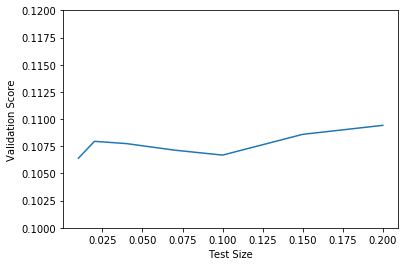

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(tsize_list,score_list)
plt.ylim(0.1,0.12)
plt.xlabel('Test Size')
plt.ylabel('Validation Score')

由于本项目中的数据量还是比较可观，因此在 testsize 在0.01到0.1之间时，模型的表现比较稳定，所以后续过程中可以初步确定9：1的训练-验证划分比例。

### 1.2. Random Forest Optimizing

随机森林算法中涉及的参数有很多，通过之前项目的学习，我计划对n_estimators，max_features 以及 max_depth 这三个主要参数进行优化搜索。各个参数的取值范围及取值理由如下：

- n_estimators: 初步选取 50,80,100,150,200 进行试算，10为算法的默认取值，100为大部分文献中的取值。
- max_features：初步选取 0.1,0.2,0.4,0.6,0.8,1 进行试算，该值确定的是决策树的特征量，我采用了比例设定的方式覆盖了多数文献中使用的比例范围。
- max_depth: 初步选择2到8进行试算。

最初准备使用网格搜索法对上述所有参数进行综合搜索。但是经过尝试和思考，认为直接进行网格搜索有两个不足：

- 对于上述三个参数，现在的取值范围都是根据类似研究中的取值来确立的，不能保证在既定范围内存在理想的较优值，也无法获知每一项参数变动对结果准确性的影响；
- 网格搜索的计算量庞大，而暂时没有找到容易上手的随机森林gpu加速算法，虽然通过cpu多线程（$\times 12 $）并行可以对计算过程提速，但是个人计算机的内存不足以支撑多个模型并行计算，只能采用单线程，因此计算的时间成本极高。

因此，计划首先对各个参数进行分项计算，得出每一项参数的较优值，然后再重新划定合理的范围进行网格搜索优化。

#### 1.2.1. n_estimators optimizing

In [3]:
nes = np.array([50,100,150,200,250])
mfs = np.array([0.1,0.2,0.4,0.6,0.8,1])
mds = np.arange(2,9,1)

In [6]:
# 首先研究n estimator对结果的影响，这里使用了10拆分的交叉验证

nes_scores = {}
for ne in nes:
    print('when n estimator = ',ne)
    RF_beta = RandomForestRegressor(n_estimators=ne)
    scores = cross_val_score(RF_beta,X,y,scoring=scorer,cv=10, n_jobs=12)
    nes_scores['{}'.format(ne)]=scores
    print('scores = ',scores)

when n estimator =  50
scores =  [0.13628862 0.14037945 0.14836998 0.11470293 0.14591237 0.12210915
 0.17767619 0.12450922 0.12959932 0.15855347]
when n estimator =  100
scores =  [0.13560081 0.13959793 0.14710886 0.11409642 0.14536743 0.1207854
 0.17666403 0.12401182 0.12884184 0.15740034]
when n estimator =  150
scores =  [0.13537927 0.1392616  0.14669086 0.11397134 0.14522474 0.12087506
 0.17635782 0.12405047 0.12872758 0.15743372]
when n estimator =  200
scores =  [0.1352734  0.13914744 0.14665855 0.11388815 0.14516812 0.12107704
 0.17639801 0.12403763 0.12839755 0.15809819]
when n estimator =  250
scores =  [0.13518981 0.13904203 0.14644017 0.11383543 0.14511845 0.1210241
 0.17663028 0.12388465 0.12839672 0.15821991]


In [3]:
import matplotlib.pyplot as plt

ness = np.loadtxt('n_estimators')
nes = ness.T[0]
nes_scores = ness.T[1:].T

Text(0,0.5,'mean score of 10 cv')

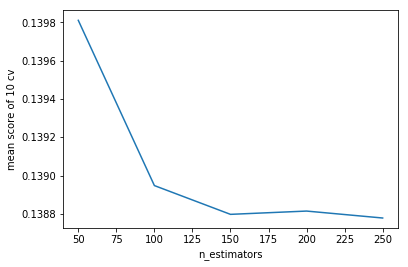

In [4]:
nes_mean = [np.mean(i) for i in nes_scores]
nes_max = [max(i) for i in nes_scores]
nes_min = [min(i) for i in nes_scores]

plt.plot(nes, nes_mean)
plt.xlabel('n_estimators')
plt.ylabel('mean score of 10 cv')
# plt.plot(nes, nes_max)
# plt.plot(nes,nes_min)

可以看出，随着 n estimators 数量的增加，模型的得分均值也在增加，当 n estimators 大于100时，曲线的变化逐渐变缓，为了兼顾计算经济性和准确性，我选择150作为一个较优的n_estimators 值。

#### 1.2.2. max_features optimizing

In [5]:
# 搜索最优化的 max features
mfs_scores = {}
for mf in mfs:
    print('when max features = ',mf)
    RF_beta = RandomForestRegressor(max_features=mf,n_estimators=150)
    scores = cross_val_score(RF_beta,X,y,scoring=scorer,cv=10)
    mfs_scores['{}'.format(mf)]=scores  
    print('scores = ',scores)  

when max features =  0.1
scores =  [0.1256808  0.128594   0.14969299 0.11116018 0.1400017  0.11704749
 0.16543282 0.12737558 0.12570587 0.15151046]
when max features =  0.2
scores =  [0.12663005 0.12669841 0.14195129 0.10765672 0.13772763 0.11232503
 0.16325432 0.12076588 0.12549353 0.15018254]
when max features =  0.4
scores =  [0.12765853 0.12967447 0.13713562 0.10720935 0.13942102 0.11185221
 0.1630444  0.11906302 0.12674461 0.15170394]
when max features =  0.6
scores =  [0.12966212 0.13246622 0.1379544  0.10884295 0.14098655 0.1140232
 0.1658465  0.11964002 0.12694696 0.15314147]
when max features =  0.8
scores =  [0.13174698 0.13551271 0.14029255 0.11053444 0.14262687 0.11687965
 0.16933752 0.12113443 0.12732014 0.15493536]
when max features =  1.0
scores =  [0.13518632 0.13880886 0.14698743 0.11381826 0.14520095 0.12091177
 0.17635712 0.12395451 0.12874521 0.15778401]


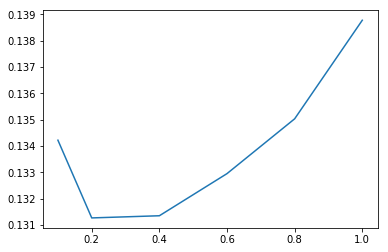

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
mfs_scores.keys()
mfs_mean = [np.mean(i) for i in mfs_scores.values()]
plt.plot(mfs,mfs_mean)

可以看出，当 max features 参数为 0.2 时结果较优。

#### 1.2.3. max_depth optimizing

In [13]:
# 搜索最优化的 max depth
mds_scores = {}
for md in mds:
    print('when max depth = ',md)
    RF_beta = RandomForestRegressor(max_depth=md, max_features=0.2,n_estimators=150)
    scores = cross_val_score(RF_beta,X,y,scoring=scorer,cv=10)
    mds_scores['{}'.format(mf)]=scores  
    print('scores = ',scores)  

when max depth =  2
scores =  [0.32389222 0.31510069 0.35112031 0.30461062 0.34060128 0.29180581
 0.34175034 0.3067801  0.30741662 0.31636857]
when max depth =  3
scores =  [0.27443821 0.26837757 0.29944786 0.25630618 0.28156744 0.25145261
 0.29713876 0.2610575  0.26536804 0.28429023]
when max depth =  4
scores =  [0.24672871 0.2451479  0.2669376  0.222174   0.24875107 0.22040662
 0.26384985 0.23216074 0.22955435 0.25025197]
when max depth =  5
scores =  [0.22306858 0.21659641 0.24530004 0.19704117 0.22448664 0.19977638
 0.24144082 0.21289937 0.20706372 0.23312568]
when max depth =  6
scores =  [0.20873303 0.20623528 0.23145217 0.18361463 0.20989579 0.18673576
 0.23132475 0.19124883 0.19334759 0.2191843 ]
when max depth =  7
scores =  [0.20100416 0.19615637 0.22011172 0.171816   0.19917017 0.17780515
 0.22160309 0.18680463 0.18479672 0.21013688]
when max depth =  8
scores =  [0.19296258 0.18841419 0.20936305 0.16428586 0.19100832 0.16839905
 0.21344181 0.17605831 0.17681137 0.20366781]

In [14]:
# 搜索更多的 max depth
for md in [9,10,12,14,16,18,20]:
    print('when max depth = ',md)
    RF_beta = RandomForestRegressor(max_depth=md, max_features=0.2,n_estimators=150)
    scores = cross_val_score(RF_beta,X,y,scoring=scorer,cv=10)
    mds_scores['{}'.format(mf)]=scores  
    print('scores = ',scores)  

when max depth =  9
scores =  [0.18568173 0.18161143 0.2005699  0.1574369  0.1818592  0.16316372
 0.20693501 0.168371   0.17101635 0.19777485]
when max depth =  10
scores =  [0.18067557 0.17383734 0.19200254 0.15083353 0.1762474  0.15621074
 0.1985095  0.16165342 0.16325187 0.19110468]
when max depth =  12
scores =  [0.16672707 0.16032821 0.17493494 0.13887235 0.16452867 0.14287158
 0.18508601 0.14961444 0.15122064 0.18029675]
when max depth =  14
scores =  [0.15569221 0.14708117 0.15966472 0.12880075 0.15311211 0.13255673
 0.17576718 0.14032295 0.13991304 0.16909011]
when max depth =  16
scores =  [0.1438252  0.13762252 0.15130266 0.11996414 0.14515278 0.12344172
 0.16783531 0.13222496 0.13305747 0.16025712]
when max depth =  18
scores =  [0.13628264 0.13125032 0.14641951 0.11430434 0.14034486 0.11844775
 0.16437325 0.12699175 0.12803095 0.15475521]
when max depth =  20
scores =  [0.13008003 0.12762001 0.14419317 0.11053508 0.13817061 0.11475449
 0.1636139  0.12325113 0.1255633  0.151

In [15]:
# 搜索更多的 max depth
for md in [22,25,28,30,33,35,38,40]:
    print('when max depth = ',md)
    RF_beta = RandomForestRegressor(max_depth=md, max_features=0.2,n_estimators=150)
    scores = cross_val_score(RF_beta,X,y,scoring=scorer,cv=10)
    mds_scores['{}'.format(mf)]=scores  
    print('scores = ',scores)  

when max depth =  22
scores =  [0.12797605 0.12616157 0.14248072 0.10850202 0.13708456 0.11328278
 0.16254793 0.12107453 0.1247512  0.15009877]
when max depth =  25
scores =  [0.12646697 0.1259587  0.14239037 0.10752337 0.13710706 0.11244243
 0.16137547 0.12088309 0.12480851 0.15047758]
when max depth =  28
scores =  [0.12666125 0.12648064 0.14244988 0.1073981  0.13770762 0.11242738
 0.16306895 0.12050379 0.12538052 0.14987719]
when max depth =  30
scores =  [0.1262269  0.12659923 0.14270756 0.10739494 0.13775006 0.11229355
 0.16289716 0.12047142 0.1257891  0.15004283]
when max depth =  33
scores =  [0.12666333 0.12631873 0.14286955 0.1073587  0.13788371 0.11279454
 0.16100102 0.12059629 0.12547295 0.15055946]
when max depth =  35
scores =  [0.12661435 0.12659523 0.14266988 0.10735161 0.13765053 0.1123806
 0.1638061  0.1204807  0.12558775 0.15041548]
when max depth =  38
scores =  [0.12621686 0.12627542 0.142972   0.10743107 0.13772164 0.11248503
 0.16399394 0.12030058 0.12552682 0.150

Text(0,0.5,'rmspe')

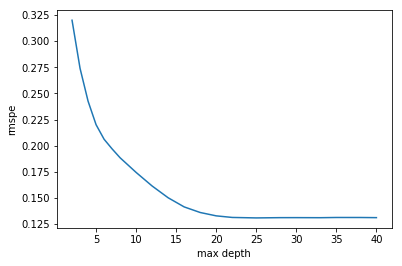

In [5]:
mdss = np.loadtxt('max_depth')
mds = mdss.T[0]
mds_scores = mdss.T[1:].T

mds_mean = [np.mean(i) for i in mds_scores]
mds_max = [max(i) for i in mds_scores]
mds_min = [min(i) for i in mds_scores]

plt.plot(mds, mds_mean)
# plt.plot(mds, mds_max)
# plt.plot(mds, mds_min)

plt.xlabel('max depth')
plt.ylabel('rmspe')

可以看出，随着最大深度的增加，交叉验证结果的最大值、均值和最小值趋势一致，均为先快速降低，最大深度大于22后则区域稳定，在最大深度大于25后出现少量的反弹。因此，综合结果准确性和计算经济性，选择22最为较优的最大深度。
 
#### 1.2.4. GridSearch

通过以上三个步骤的试算，可以初步认为，三项参数的较优值分别为：

- n_estimators:150
- max_features:0.2
- max_depth:22

现在在上面三个值的基础上，给予每个参数一定的变化范围，并进行网格搜索。网格搜索的过程中，由于需要大量的计算（2310次fit），个人电脑运行时间过长，内存资源也不足以支撑计算，故使用腾讯云按量计费主机（56vCPU，455GB内存）进行计算，将下面的代码整理为单独脚本 gcv-56core.py 将计算结果保存为gcv.csv文件。

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.05, random_state=42)

RF_cherry = RandomForestRegressor(random_state=42)
parameters = {'n_estimators':np.arange(125,176,5),
             'max_features':np.arange(0.15,0.21,0.02),
             'max_depth':np.arange(18,25,1)}
kfold = KFold(n_splits=10)
grid = GridSearchCV(RF_cherry, parameters, scorer, cv=kfold, n_jobs=-1)
grid = grid.fit(X_train, y_train)

print('best score: %f'%grid.best_score_)
print('best parameters:')
for key in parameters.keys():
    print('%s: %d'%(key, reg.get_params()[key]))

print('test score: %f'%reg.score(X_test, y_test))

gridcv_results = pd.DataFrame(grid.cv_results_).T

gridcv_results.to_csv('gcv.csv')

In [27]:
gridcv_results = pd.read_csv('gcv.csv',index_col=False)
gridcv_results = gridcv_results.set_index('content', inplace=False, drop=True).T
gridcv_results.head()

content,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,309.6326595,3.914691428,8.504561472,1.07375785,18,0.15,125,"{'max_depth': 18, 'max_features': 0.15, 'n_est...",0.124845375,0.125739628,...,0.108687483,0.108769263,0.10794622,0.10882983,0.108497256,0.108288746,0.108421755,0.108204979,0.108481125,0.000280063
1,321.331032,5.085320582,9.387311363,0.720473718,18,0.15,130,"{'max_depth': 18, 'max_features': 0.15, 'n_est...",0.12472514,0.125726524,...,0.108596825,0.10869643,0.10780863,0.108727162,0.108297842,0.108316425,0.108303729,0.108023851,0.10837888,0.000286277
2,343.8468857,6.116478305,11.39310119,1.471312733,18,0.15,135,"{'max_depth': 18, 'max_features': 0.15, 'n_est...",0.124618411,0.125687603,...,0.108505178,0.108608271,0.107763474,0.108673333,0.108220368,0.108316417,0.108231927,0.108022651,0.108314396,0.000263431
3,364.2421949,4.415601637,13.08148572,1.095307742,18,0.15,140,"{'max_depth': 18, 'max_features': 0.15, 'n_est...",0.124562813,0.125570846,...,0.108485938,0.108613798,0.107634631,0.108672174,0.108191024,0.108309458,0.108221269,0.108072637,0.10828483,0.000286652
4,388.7014971,7.345377781,14.90018544,1.4808142,18,0.15,145,"{'max_depth': 18, 'max_features': 0.15, 'n_est...",0.124545357,0.125675886,...,0.108452339,0.108678094,0.107691948,0.108760111,0.108210385,0.108353146,0.108364353,0.108080393,0.108327378,0.000285177


In [65]:
# 查看最优验证集参数
for p,s in zip(gridcv_results.params,gridcv_results.mean_test_score):
    if s==min(gridcv_results.mean_test_score):
        print('when parameter is :',p)
        print('got the best mean test score :',s)
    if s==max(gridcv_results.mean_test_score):
        print('when parameter is :',p)
        print('got the worst mean test score :',s)

when parameter is : {'max_depth': 18, 'max_features': 0.15, 'n_estimators': 125}
got the worst mean test score : 0.125387769
when parameter is : {'max_depth': 24, 'max_features': 0.18999999999999997, 'n_estimators': 165}
got the best mean test score : 0.106439731


In [64]:
# 查看最优训练集参数
for p,s in zip(gridcv_results.params,gridcv_results.mean_train_score):
    if s==min(gridcv_results.mean_train_score):
        print('when parameter is :',p)
        print('got the best mean train score :',s)
    if s==max(gridcv_results.mean_train_score):
        print('when parameter is :',p)
        print('got the worst mean train score :',s)

when parameter is : {'max_depth': 18, 'max_features': 0.15, 'n_estimators': 125}
got the worst mean train score : 0.108481125
when parameter is : {'max_depth': 24, 'max_features': 0.18999999999999997, 'n_estimators': 175}
got the best mean train score : 0.057350136


可以看出，max depth 和 max features 在验证集和训练集上的最优值一致，分别为24 和 0.19。n_estimators的最优质在测试机和训练集上有差异，但是差异不大，以测试集结果为准，取165。

### 1.3. Random Forest Final

通过1.2章节的尝试，可以基本确定随机森林的模型参数为：

- n_estimators:165
- max_features:0.19
- max_depth:24

将本步骤的随机森林回归器命名为 RF_danny， 使用上述三个参数对整个训练集进行训练。

In [6]:
RF_danny = RandomForestRegressor(max_depth=24, max_features=0.19, n_estimators=165)
RF_danny = RF_danny.fit(X,y)

将Danny应用到测试集上，要注意的是，在训练集中我剔除了关门、销售额为0的情况。所以在测试集中，我默认将所有Open=0的样本的销售额判断为0。

In [11]:
# RF_danny.feature_importances_
sorted(zip(map(lambda x: round(x, 4), RF_danny.feature_importances_), X.columns.values), reverse=True)

[(0.2445, 'Sales2014'),
 (0.1812, 'Sales2013'),
 (0.169, 'Sales2015'),
 (0.1371, 'Promo'),
 (0.0686, 'DayOfWeek'),
 (0.0356, 'DayOfMonth'),
 (0.0242, 'WeekOfYear'),
 (0.0156, 'Month'),
 (0.0155, 'CompetitionDistance'),
 (0.0153, 'CompetitionTime'),
 (0.0137, 'Heat2013'),
 (0.0135, 'Heat2015'),
 (0.013, 'Heat2014'),
 (0.0119, 'Promo2Time'),
 (0.0099, 'Year'),
 (0.0055, 'is_type_a'),
 (0.0038, 'is_scale_a'),
 (0.0036, 'is_scale_c'),
 (0.0036, 'SchoolHoliday'),
 (0.0032, 'Promo2'),
 (0.0025, 'is_type_d'),
 (0.0024, 'is_type_b'),
 (0.0019, 'is_type_c'),
 (0.0014, 'is_promo2_a'),
 (0.0012, 'is_promo2_c'),
 (0.001, 'is_promo2_b'),
 (0.0006, 'is_state_holiday'),
 (0.0004, 'is_public_holiday'),
 (0.0003, 'is_scale_b'),
 (0.0001, 'is_easter'),
 (0.0, 'is_christmas'),
 (0.0, 'Open')]

In [48]:
# 定义一个函数来使用训练后的模型进行预测并整理结果
def pred_n_submit(model,test,submission_name):
    # 求出预测值
    log_pred = model.predict(test)
    pred = []
    for i in range(len(log_pred)):
        if test.Open.values[i]==0.0:
            pred.append(0.0)
        else:pred.append(np.e**log_pred[i])
    
    # 将测试集中所有Open=0的样本判断为0销售额
    pred_revised = []
    for i in range(len(pred)):
        if test.Open.values[i]==0.0:
            pred_revised.append(0.0)
        else:pred_revised.append(pred[i])
    
    # 将结果整理为submission格式
    id_list = pd.read_csv('data/test.csv').Id.values
    submission = pd.DataFrame({'Id':id_list,
                              'Sales':pred_revised})
    submission.to_csv('submission/{}.csv'.format(submission_name),index=False)

RF_alpha = RandomForestRegressor().fit(X,y)
RF_beta = RandomForestRegressor(max_depth=22, max_features=0.2, n_estimators=150).fit(X,y)
RF_danny = RandomForestRegressor(max_depth=24, max_features=0.19, n_estimators=165).fit(X,y)

pred_n_submit(RF_alpha,cesar_test,'RF_alpha_submission')
pred_n_submit(RF_beta,cesar_test,'RF_beta_submission')
pred_n_submit(RF_danny,cesar_test,'RF_danny_submission')

将未经优化过的模型alpha，经过分项优化的模型beta以及使用网格搜索法优化的模型danny分别应用到整个训练集cesar_train上进行训练，并将预测结果整理为submission格式。提交至kaggle后得到的评分如下：

|Model|Private score|Public score|
|:-|:-|:-|
|Alpha|0.13594|0.13022|
|Beta|0.12487|0.11205|
|Danny|0.12421|0.11103|

Text(0,0.5,'RMSPE score')

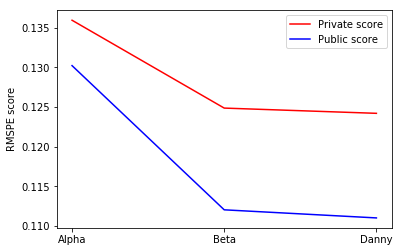

In [27]:
import matplotlib.pyplot as plt

models = ['Alpha','Beta','Danny']
private_score = [0.13594,0.12487,0.12421]
public_score = [0.13022,0.11205,0.11103]

fig,ax = plt.subplots()
ax.plot([1,2,3],private_score,'-r',label='Private score')
ax.plot([1,2,3],public_score,'-b',label='Public score')
ax.legend()
plt.xticks([1,2,3],models)
ax.set_ylabel('RMSPE score')

## 2. XGBoost

In [8]:
# 引入必要的库
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold

import time

In [9]:
# 将测试集中所有Open=0的样本判断为0销售额
# 将取对数的sales值还原

# 定义一个函数来使用训练后的模型进行预测并整理结果
def submit_xgb(model,cesar_test,name):
    test = xgb.DMatrix(cesar_test)
    pred = model.predict(test)
    pred_revised = []
    for i in range(len(pred)):
        if cesar_test.Open.values[i]==0.0:
            pred_revised.append(0.0)
        else:pred_revised.append(np.e**pred[i])

    # 将结果整理为submission格式
    id_list = pd.read_csv('data/test.csv').Id.values
    submission = pd.DataFrame({'Id':id_list,
                              'Sales':pred_revised})
    submission.to_csv('submission/{}.csv'.format(name),index=False)

In [10]:
# thanks to https://www.kaggle.com/qmaruf/xgboost-in-python-with-rmspe
# 定义评分标准函数
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [11]:
# 读入数据并进行训练验证划分
cesar_train = pd.read_csv('data/cesar_train.csv',index_col=False)
cesar_test = pd.read_csv('data/cesar_test.csv',index_col=False)
cesar_xgb_test = xgb.DMatrix(cesar_test)
X = cesar_train.drop(['Sales'],axis=1)
y = cesar_train.Sales

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)
dtrain = xgb.DMatrix(X_train,y_train)
dtest = xgb.DMatrix(X_test,y_test)

### 2.1. Aaron

建立简单的xgboost模型对数据进行试算

In [59]:
# 建立简单参数的xgboost模型

param_aaron = {'objective':'reg:linear',
               'eta':0.1,
               'booster':'gbtree',
               'predictor':'gpu_predictor',
               'tree_method':'gpu_hist',
              }

rounds = 10000
watchlist = [(dtest, 'eval'), (dtrain, 'train')]

time1 = time.time()
bst_aaron = xgb.train(param_aaron,dtrain,rounds,watchlist,verbose_eval=int(rounds/10),feval=rmspe_xg)
print((time.time()-time1)/60,'minutes')

submit_xgb(bst_aaron,cesar_test,'xgb_arron_submission')

[0]	eval-rmse:7.43262	train-rmse:7.43048	eval-rmspe:0.999527	train-rmspe:0.999527
[1000]	eval-rmse:0.100679	train-rmse:0.09739	eval-rmspe:0.11652	train-rmspe:0.157209
[2000]	eval-rmse:0.09237	train-rmse:0.087568	eval-rmspe:0.107627	train-rmspe:0.131082
[3000]	eval-rmse:0.08925	train-rmse:0.082716	eval-rmspe:0.104339	train-rmspe:0.113359
[4000]	eval-rmse:0.087688	train-rmse:0.07955	eval-rmspe:0.103056	train-rmspe:0.106788
[5000]	eval-rmse:0.08686	train-rmse:0.077215	eval-rmspe:0.10241	train-rmspe:0.101609
[6000]	eval-rmse:0.086179	train-rmse:0.075261	eval-rmspe:0.101921	train-rmspe:0.094966
[7000]	eval-rmse:0.085695	train-rmse:0.073602	eval-rmspe:0.101498	train-rmspe:0.090837
[8000]	eval-rmse:0.085474	train-rmse:0.07217	eval-rmspe:0.101388	train-rmspe:0.086459
[9000]	eval-rmse:0.085153	train-rmse:0.0709	eval-rmspe:0.100966	train-rmspe:0.084503
[9999]	eval-rmse:0.084938	train-rmse:0.069734	eval-rmspe:0.100759	train-rmspe:0.082399
13.379349267482757 minutes


### 2.2. Blake
增加一些参数，使模型的保守性增强

In [33]:
param_blake = {'objective':'reg:linear',
               'eta':0.1,
               'booster':'gbtree',
               'predictor':'gpu_predictor',
               'tree_method':'gpu_hist',
               'alpha':2,
               'subsample':0.8,
               'gama':2,
               'min_child_weight':50
              }

time1 = time.time()
bst_blake = xgb.train(param_blake,dtrain,rounds,watchlist,verbose_eval=int(rounds/10),feval=rmspe_xg)
print((time.time()-time1)/60,'minutes')

submit_xgb(bst_blake,cesar_test,'xgb_blake_submission')

[0]	eval-rmse:7.4327	train-rmse:7.43052	eval-rmspe:0.999527	train-rmspe:0.999527
[1000]	eval-rmse:0.102368	train-rmse:0.099792	eval-rmspe:0.117817	train-rmspe:0.173777
[2000]	eval-rmse:0.095118	train-rmse:0.091635	eval-rmspe:0.11038	train-rmspe:0.166032
[3000]	eval-rmse:0.092046	train-rmse:0.087643	eval-rmspe:0.107291	train-rmspe:0.160246
[4000]	eval-rmse:0.090424	train-rmse:0.085174	eval-rmspe:0.105745	train-rmspe:0.155819
[5000]	eval-rmse:0.089321	train-rmse:0.08343	eval-rmspe:0.104633	train-rmspe:0.151656
[6000]	eval-rmse:0.08859	train-rmse:0.082061	eval-rmspe:0.1042	train-rmspe:0.147569
[7000]	eval-rmse:0.088017	train-rmse:0.080924	eval-rmspe:0.103526	train-rmspe:0.143914
[8000]	eval-rmse:0.087595	train-rmse:0.079977	eval-rmspe:0.103209	train-rmspe:0.140728
[9000]	eval-rmse:0.087294	train-rmse:0.079167	eval-rmspe:0.103003	train-rmspe:0.137251
[9999]	eval-rmse:0.087003	train-rmse:0.078453	eval-rmspe:0.102778	train-rmspe:0.134474
13.950365591049195 minutes


### 2.3. Further Blake
对max_depth参数进行调优，观察其对结果的影响以及计算过程中模型评分随着计算步骤增加的演变过程。

模型参数以blake为基准但是将max_depth值从4~8进行调整。

In [53]:
max_depth_params_1 = [
    {'objective': 'reg:linear', 'eta': 0.1, 'booster': 'gbtree', 'predictor': 'gpu_predictor', 'tree_method': 'gpu_hist', 'alpha': 2, 'subsample': 0.8, 'gama': 2, 'min_child_weight': 50, 'max_depth': 4},
{'objective': 'reg:linear', 'eta': 0.1, 'booster': 'gbtree', 'predictor': 'gpu_predictor', 'tree_method': 'gpu_hist', 'alpha': 2, 'subsample': 0.8, 'gama': 2, 'min_child_weight': 50, 'max_depth': 5},
{'objective': 'reg:linear', 'eta': 0.1, 'booster': 'gbtree', 'predictor': 'gpu_predictor', 'tree_method': 'gpu_hist', 'alpha': 2, 'subsample': 0.8, 'gama': 2, 'min_child_weight': 50, 'max_depth': 6},
{'objective': 'reg:linear', 'eta': 0.1, 'booster': 'gbtree', 'predictor': 'gpu_predictor', 'tree_method': 'gpu_hist', 'alpha': 2, 'subsample': 0.8, 'gama': 2, 'min_child_weight': 50, 'max_depth': 7},
{'objective': 'reg:linear', 'eta': 0.1, 'booster': 'gbtree', 'predictor': 'gpu_predictor', 'tree_method': 'gpu_hist', 'alpha': 2, 'subsample': 0.8, 'gama': 2, 'min_child_weight': 50, 'max_depth': 8}
]

# for max_depth,params in zip([4,5,6,7,8],temp):
#     params['max_depth']=max_depth
#     print(params)
#     max_depth_params_1.append(params)

In [57]:
models_1 = [xgb.train(param,dtrain,rounds,watchlist,verbose_eval=int(rounds/10),feval=rmspe_xg) for param in max_depth_params_1]

[0]	eval-rmse:7.4328	train-rmse:7.43057	eval-rmspe:0.999527	train-rmspe:0.999527
[1000]	eval-rmse:0.125611	train-rmse:0.124154	eval-rmspe:0.142791	train-rmspe:0.194472
[2000]	eval-rmse:0.114204	train-rmse:0.112591	eval-rmspe:0.13005	train-rmspe:0.185434
[3000]	eval-rmse:0.108568	train-rmse:0.106703	eval-rmspe:0.123943	train-rmspe:0.181137
[4000]	eval-rmse:0.104995	train-rmse:0.102969	eval-rmspe:0.120316	train-rmspe:0.179232
[5000]	eval-rmse:0.102366	train-rmse:0.100324	eval-rmspe:0.117662	train-rmspe:0.177676
[6000]	eval-rmse:0.100489	train-rmse:0.09832	eval-rmspe:0.11561	train-rmspe:0.17574
[7000]	eval-rmse:0.099042	train-rmse:0.096744	eval-rmspe:0.114191	train-rmspe:0.174297
[8000]	eval-rmse:0.097997	train-rmse:0.095508	eval-rmspe:0.113206	train-rmspe:0.172605
[9000]	eval-rmse:0.097134	train-rmse:0.09447	eval-rmspe:0.112296	train-rmspe:0.170973
[9999]	eval-rmse:0.096438	train-rmse:0.093561	eval-rmspe:0.111682	train-rmspe:0.170311
[0]	eval-rmse:7.43269	train-rmse:7.43053	eval-rmspe:0.

NameError: name 'model_1' is not defined

In [58]:
for model,max_depth in zip(models_1,[4,5,6,7,8]): 
    sub_name = 'blake_max_depth={}'.format(max_depth)
    submit_xgb(model,cesar_test,sub_name)

增加三组模型，将max_depth的调整范围扩大至4~11。

In [60]:
max_depth_params_2 = [
    {'objective': 'reg:linear', 'eta': 0.1, 'booster': 'gbtree', 'predictor': 'gpu_predictor', 'tree_method': 'gpu_hist', 'alpha': 2, 'subsample': 0.8, 'gama': 2, 'min_child_weight': 50, 'max_depth': 9},
{'objective': 'reg:linear', 'eta': 0.1, 'booster': 'gbtree', 'predictor': 'gpu_predictor', 'tree_method': 'gpu_hist', 'alpha': 2, 'subsample': 0.8, 'gama': 2, 'min_child_weight': 50, 'max_depth': 10},
{'objective': 'reg:linear', 'eta': 0.1, 'booster': 'gbtree', 'predictor': 'gpu_predictor', 'tree_method': 'gpu_hist', 'alpha': 2, 'subsample': 0.8, 'gama': 2, 'min_child_weight': 50, 'max_depth': 11}
]

models_2 = [xgb.train(param,dtrain,rounds,watchlist,verbose_eval=int(rounds/10),feval=rmspe_xg) for param in max_depth_params_2]

for model,max_depth in zip(models_2,[9,10,11]): 
    sub_name = 'blake_max_depth={}'.format(max_depth)
    submit_xgb(model,cesar_test,sub_name)

[0]	eval-rmse:7.43277	train-rmse:7.43052	eval-rmspe:0.999527	train-rmspe:0.999528
[1000]	eval-rmse:0.089091	train-rmse:0.082799	eval-rmspe:0.105209	train-rmspe:0.148787
[2000]	eval-rmse:0.086123	train-rmse:0.076599	eval-rmspe:0.102292	train-rmspe:0.127102
[3000]	eval-rmse:0.085121	train-rmse:0.073222	eval-rmspe:0.10069	train-rmspe:0.112555
[4000]	eval-rmse:0.084712	train-rmse:0.070845	eval-rmspe:0.100665	train-rmspe:0.102774
[5000]	eval-rmse:0.084516	train-rmse:0.069028	eval-rmspe:0.100647	train-rmspe:0.096115
[6000]	eval-rmse:0.084416	train-rmse:0.067585	eval-rmspe:0.100287	train-rmspe:0.089798
[7000]	eval-rmse:0.084431	train-rmse:0.066355	eval-rmspe:0.100442	train-rmspe:0.085894
[8000]	eval-rmse:0.084379	train-rmse:0.065317	eval-rmspe:0.100277	train-rmspe:0.08299
[9000]	eval-rmse:0.084324	train-rmse:0.064405	eval-rmspe:0.100075	train-rmspe:0.08041
[9999]	eval-rmse:0.084299	train-rmse:0.063572	eval-rmspe:0.100081	train-rmspe:0.077948
[0]	eval-rmse:7.43277	train-rmse:7.43052	eval-rmspe

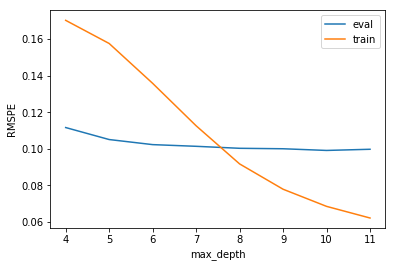

In [6]:
# 观察最大深度对模型评分的影响
def plt_depth_results():
    import matplotlib.pyplot as plt
    max_depth = [4,5,6,7,8,9,10,11]
    eval_rmspe = [0.111682,0.105121,0.102344,0.101419,0.100333,0.100081,0.099161,0.099799]
    train_rmspe = [0.170311,0.157656,0.135865,0.11265,0.091798,0.077948,0.068574,0.062207]
    plt.plot(max_depth,eval_rmspe,label='eval')
    plt.plot(max_depth,train_rmspe,label='train')
    plt.legend()
    plt.xlabel('max_depth')
    plt.ylabel('RMSPE')
    plt.show()

plt_depth_results()

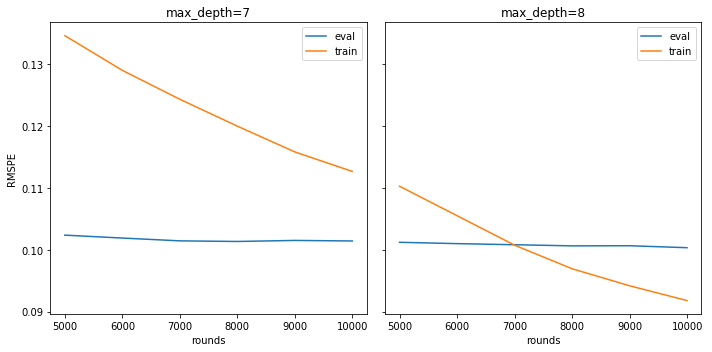

In [41]:
# 观察对于7，8两个最大深度，模型评分随计算步骤增加而发生变化的规律。 
def plt_7_8():
    import matplotlib.pyplot as plt
    eval_rmspe_7 = [0.999527,0.110709,0.105673,0.104067,0.103087,0.102361,0.101892,0.101438,0.10134,0.101508,0.101419]
    eval_rmspe_8 = [0.999527,0.105707,0.10285,0.102085,0.101411,0.101205,0.100991,0.100812,0.100631,0.100652,0.100333]

    train_rmspe_7 = [0.999527,0.171532,0.15841,0.149674,0.14038,0.134576,0.128973,0.124304,0.119962,0.115796,0.11265]
    train_rmspe_8 = [0.999528,0.155701,0.14001,0.12716,0.117625,0.110258,0.1055,0.10074,0.096934,0.094185,0.091798]
    
    rounds = [0,1000,2000,3000,4000,5000,6000,7000,8000,9000,9999]
    
    fig,(ax1,ax2) = plt.subplots(1,2,sharex=True,sharey=True,figsize=(10,5))

    
    ax1.plot(rounds[5:],eval_rmspe_7[5:],label='eval')
    ax1.plot(rounds[5:],train_rmspe_7[5:],label='train')
    ax1.set_xlabel('rounds')
    ax1.set_ylabel('RMSPE')
    ax1.set_title('max_depth=7')
    ax1.legend()
    ax2.plot(rounds[5:],eval_rmspe_8[5:],label='eval')
    ax2.plot(rounds[5:],train_rmspe_8[5:],label='train')
    ax2.set_xlabel('rounds')
    ax2.set_title('max_depth=8')
    
    ax2.legend()
    plt.tight_layout()
    plt.show()

plt_7_8()

### 2.4. Carol

取further blake中的7和8两个最大深度，根据上一步中的结果对计算次数rounds进行调整后将两个模型的预测结果进行平均

In [43]:
param_carol_7 = {'objective': 'reg:linear', 'eta': 0.1, 'booster': 'gbtree', 'predictor': 'gpu_predictor', 'tree_method': 'gpu_hist', 'alpha': 2, 'subsample': 0.8, 'gama': 2, 'min_child_weight': 50, 'max_depth': 7}
param_carol_8 = {'objective': 'reg:linear', 'eta': 0.1, 'booster': 'gbtree', 'predictor': 'gpu_predictor', 'tree_method': 'gpu_hist', 'alpha': 2, 'subsample': 0.8, 'gama': 2, 'min_child_weight': 50, 'max_depth': 8}

carol_train = xgb.DMatrix(X,y)
carol_7 = xgb.train(param_carol_7,carol_train,13000,feval=rmspe_xg)
carol_8 = xgb.train(param_carol_8,carol_train,7000,feval=rmspe_xg)

In [46]:
test = xgb.DMatrix(cesar_test)
pred_7 = carol_7.predict(test)
pred_8 = carol_8.predict(test)
pred_mean = (pred_7+pred_8)/2
pred_mean

array([8.304365, 8.895796, 9.090679, ..., 8.778517, 9.974646, 8.941208],
      dtype=float32)

In [47]:
pred_revised = []
for i in range(len(pred_mean)):
    if cesar_test.Open.values[i]==0.0:
        pred_revised.append(0.0)
    else:pred_revised.append(np.e**pred_mean[i])

name = 'xgb_carol'
# 将结果整理为submission格式
id_list = pd.read_csv('data/test.csv').Id.values
submission = pd.DataFrame({'Id':id_list,
                          'Sales':pred_revised})
submission.to_csv('submission/{}.csv'.format(name),index=False)

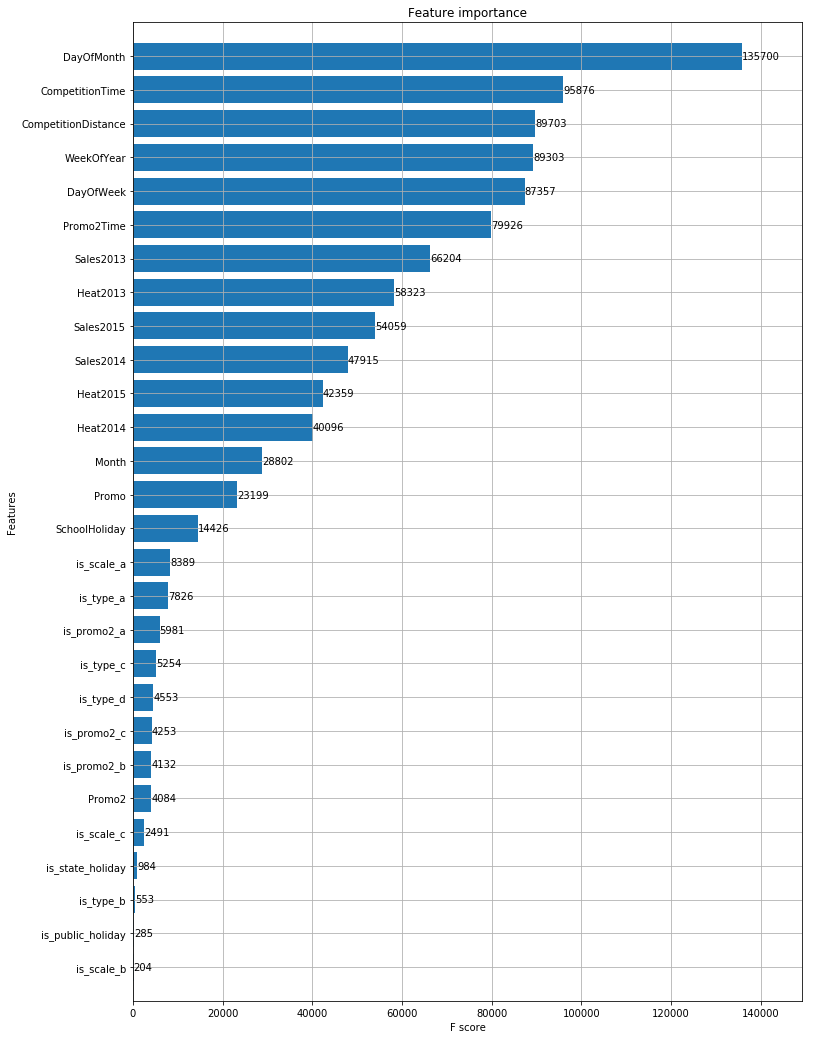

In [89]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(carol_7, max_num_features=50, height=0.8, ax=ax)
plt.show()

## 3. Fusion


In [50]:
# 引入必要的库
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd

# thanks to https://www.kaggle.com/qmaruf/xgboost-in-python-with-rmspe
# 定义评分标准函数
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [67]:
# 读入数据
cesar_train = pd.read_csv('data/cesar_train.csv',index_col=False)
cesar_test = pd.read_csv('data/cesar_test.csv',index_col=False)
test = xgb.DMatrix(cesar_test)

In [55]:
# 将训练集打乱
from sklearn.utils import shuffle
cesar_train = shuffle(cesar_train)

In [82]:
# 将完整训练集拆分为4个训练集
locs = [0,200000,400000,600000,len(cesar_train)]
trains = [cesar_train[locs[i]:locs[i+1]] for i in [0,1,2,3]]

In [83]:
param_carol_7 = {'objective': 'reg:linear', 'eta': 0.1, 'booster': 'gbtree', 'predictor': 'gpu_predictor', 'tree_method': 'gpu_hist', 'alpha': 2, 'subsample': 0.8, 'gama': 2, 'min_child_weight': 50, 'max_depth': 7}
param_carol_8 = {'objective': 'reg:linear', 'eta': 0.1, 'booster': 'gbtree', 'predictor': 'gpu_predictor', 'tree_method': 'gpu_hist', 'alpha': 2, 'subsample': 0.8, 'gama': 2, 'min_child_weight': 50, 'max_depth': 8}

fusion_preds = []
for train in trains:
    X = train.drop(['Sales'],axis=1)
    y = train.Sales
    dtrain = xgb.DMatrix(X,y)
    carol_7 = xgb.train(param_carol_7,dtrain,13000,feval=rmspe_xg)
    carol_8 = xgb.train(param_carol_8,dtrain,7000,feval=rmspe_xg)
    pred_7 = carol_7.predict(test)
    pred_8 = carol_8.predict(test)
    fusion_pred =( pred_7+pred_8)/2
    fusion_preds.append(fusion_pred)   

In [84]:
fusion_pred = sum(np.array(fusion_preds))/len(fusion_preds)
pred_revised = []
for i in range(len(fusion_pred)):
    if cesar_test.Open.values[i]==0.0:
        pred_revised.append(0.0)
    else:pred_revised.append(np.e**fusion_pred[i])

name = 'fusion'
# 将结果整理为submission格式
id_list = pd.read_csv('data/test.csv').Id.values
submission = pd.DataFrame({'Id':id_list,
                          'Sales':pred_revised})
submission.to_csv('submission/{}.csv'.format(name),index=False)